# Module 3 - Feature extraction

To train and apply ensemble or margin classifiers like random forests or support vector machines, features must be measured from the images. Feature extraction, like region finding, requires a substantial amount of engineering and time and tweaking for a particular dataset.

Feature extraction routines assume that candidate regions have already been identified. In this module we will extract features from an example ROI from the SPC dataset. 

In [1]:
import numpy as np
import cv2
import skimage
from skimage import filters, morphology, measure, color, feature
from scipy import ndimage, interpolate
import sys
import glob
import os
from math import pi
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

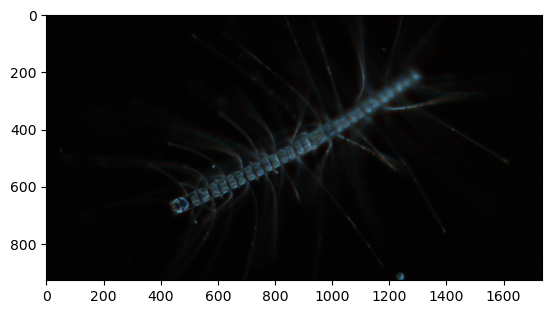

In [2]:
# get the file path of the image in the directory. here grab the diatom chain 
ptf = glob.glob(os.path.join(os.getcwd(), 'SPC*'))

# We will grab the first item in the list
img = cv2.imread(ptf[0])

# check to make sure we got the right thing
plt.imshow(img)

This region is one that we might have extracted using techniques for the previous module. Like when find the regions, we need to generate a binary mask to tell the computer what to focus on.

## Get a binary mask

To start the mask we will use a new edge detector called a Scharr filter. The Scharr filter is an operator similar to Canny that searchers for edges in the intensity image. It is well suited to finding high frequency edges.

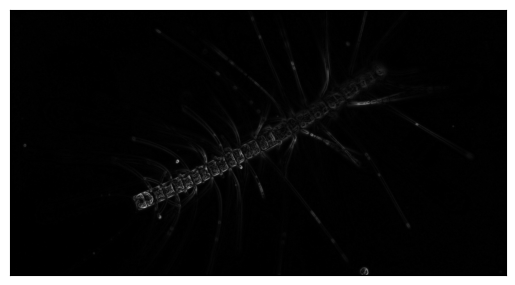

In [3]:
# make the image gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# compute the edges
edges_mag = filters.scharr(img_gray)

# see what it looks like
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(edges_mag, cmap='gray')

The Scharr filter returns gray scale values. Let's make it binary a setting a threshold that is 3 times the median value in the array. This makes our mask more apt to retain edges that using something like Otsu's method.

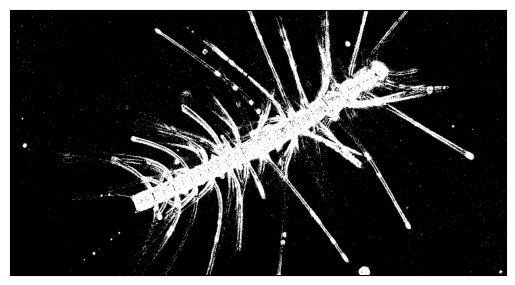

In [4]:
edges_med = np.median(edges_mag)
edges_thresh = 3*edges_med
edges = edges_mag >= edges_thresh

# see what it looks like
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(edges, cmap='gray')

That doesn't look too bad. But we want to fill in the boundary and select only the largest one for processing. To start with, we can use morphological operations to seal up some of those holes. 

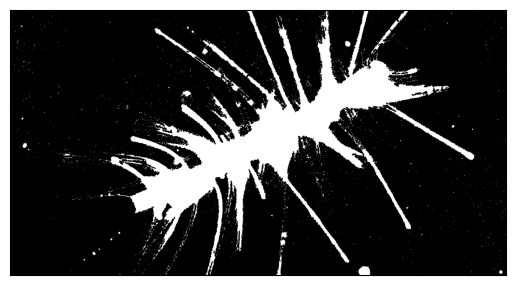

In [5]:
# these will fill in some of the holes
edges = morphology.closing(edges, morphology.square(3))
filled_edges = ndimage.binary_fill_holes(edges)

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(filled_edges, cmap='gray')

The hole filling has expanded the mask a bit. The region growing effectively got rid of the holes, but bloated the mask. Eroding, another morphological operation, will shrink it down again. 

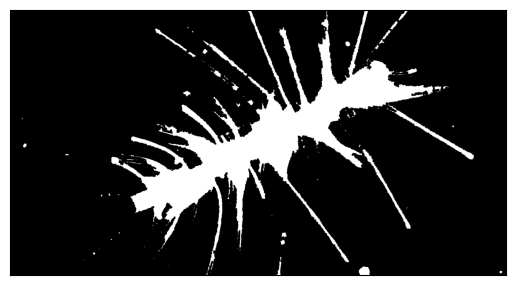

In [6]:
img_close = morphology.erosion(filled_edges, morphology.square(3))

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(img_close, cmap='gray')

It also got rid of some of the smaller noise. We can now use skimages *label* routine to find all the connected regions in the frame. 

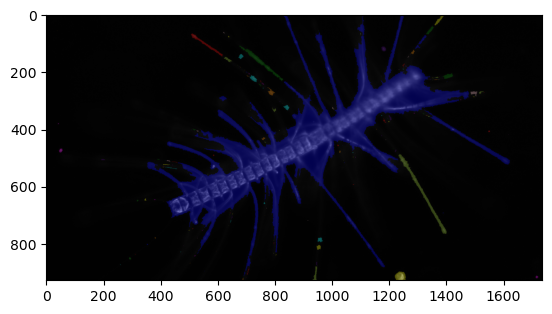

In [7]:
# pass the label routine the closed image to register connected regions.
# label_img = morphology.label(img_close, neighbors=8, background=0) # this is part of the original code but was not working

# New code added 
label_img = measure.label(img_close, connectivity=2)  # Use `connectivity` instead of `neighbors`
lab_img_color = color.label2rgb(label_img, image=img_gray)

# plot the whole image and the subregion next to each other
plt.imshow(lab_img_color, cmap='gray')

The yellow boundardy encompasses the diatom chain and gets most of the spines. Before analyzing it, we need to select only the largest boundary in the frame. Regionprops will extract this information.

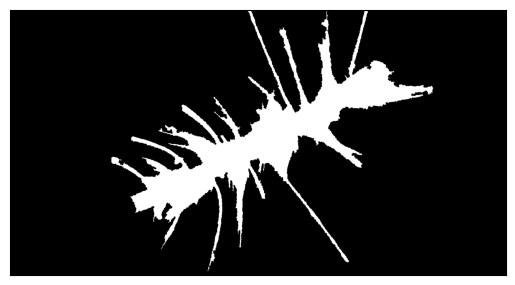

In [8]:
# use region props. But this time, have it retain all the properties it can measure
# props = measure.regionprops(label_img, img_gray, coordinates='xy') # this is part of the original code but was not working
props = measure.regionprops(label_img, img_gray)
max_area = 0
max_area_ind = 0
for f in range(0,len(props)):
    if props[f].area > max_area:
        max_area = props[f].area
        max_area_ind = f

ii = max_area_ind

# now just display that area with the bounding box to make sure it got the right one.

# this selects only the pixels in the labeled image that are in the region with the biggest area
bw_mask = (label_img) == props[ii].label

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(bw_mask, cmap='gray')

And to actually see the masked image, simply multiply the original array by the binary mask.

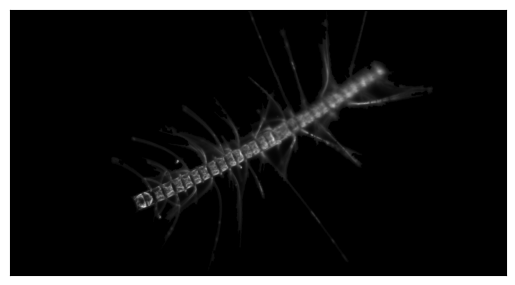

In [9]:
img_masked = img_gray * bw_mask

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(img_masked, cmap='gray')

This will be region that from which all the features will extracted. 

## Region properties

There are many types of metrics that can be used for classification. We will touch on two sets in particular: morphology and texture. All of these features will be saved to a feature vector that will be saved for later use. 

In [10]:
# create an empty feature vector to store everything
img_features = []


### Morphology

Morphological features describe the shape of the object. Some are familiar, such as the length, width, or area. Others might be a bit more exotic like the convex hull and eccentricity. 

regionprops has already computed a lot of this for us. First, let's look at what it got for the major and minor axes.

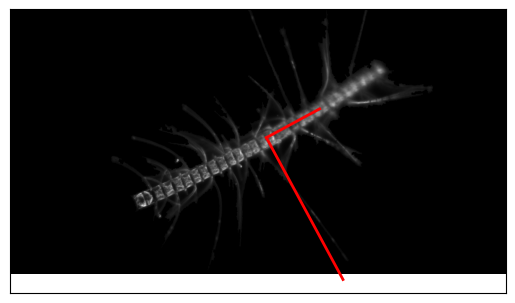

In [11]:
# grab just that biggest region
prop = props[ii]

# the center and orientation of the region have been measures. That will be used to display the axes
yy, xx = prop.centroid
angle = prop.orientation

# the measurements of the major and minor axis
maj_ax = prop.major_axis_length
min_ax = prop.minor_axis_length

# compute the coordinates of the line segment ends
x1 = xx + np.cos(angle)*0.5*maj_ax
y1 = yy - np.sin(angle)*0.5*maj_ax
x2 = xx - np.sin(angle)*0.5*min_ax
y2 = yy - np.cos(angle)*0.5*min_ax

# plot it
fig, ax = plt.subplots()
ax.imshow(img_masked, cmap='gray')

# render the major axis from the centriod
ax.plot((xx, x1), (yy, y1), 'r-', linewidth=2)

# render the minor axis from the centroid
ax.plot((xx, x2), (yy, y2), 'r-', linewidth=2)

ax.set_xticks([])
ax.set_yticks([])
plt.show()

The major and minor axes, while not perfect, give a reasonable representation of the images. 

It is often convenient to compute *invariant* features, ones that are uneffected by changes in scale, rotation, or translation. Saving such features increases the likelihood that the future machine classifer will be able to recognize another diatom chain. 

The aspect ratio is insenstive to scale. In the case of the diatom chain, it will indicate that the ROI is long and skinny. Aspect ratio is unitless and scales between 0 and 1. 0 indicates a line, 1 would be a circle.

In [12]:
aspect = prop.minor_axis_length/prop.major_axis_length

print("the aspect is: ", str(aspect))

# add it to the feature vector
img_features.append(aspect)

the aspect is:  0.3751263922335646


There are several area ratios that contain useful information. The first makes use of the convex hull of the object. The convex hull is the smallest convex polygon that contains all the pixels in a binary mask. We can see what a hull looks like using skimage.

[]

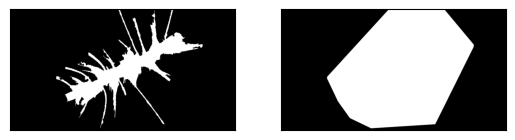

In [13]:
# compute the convex hull from the mask
hull = morphology.convex_hull_image(bw_mask)

# now plot the original mask next to the convex hull
fig, ax = plt.subplots(1, 2)

ax[0].imshow(bw_mask, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(hull, cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])

The ratio of the area of the mask to the convex hull is indicative of how spiny an object is. region_props prints this as the solidity

In [14]:
# set the data type to float to ensure we get a decimal out
sol = prop.solidity

# add it to the feature vector
img_features.append(sol)

The ratio of the area inside the region to the perimeter is also indicative of the spininess of the object. It is in essence a surface area-to-volume metric.

In [15]:
area3 = prop.area.astype(np.float64)/(prop.perimeter*prop.perimeter)

# add it to the feature vector
img_features.append(area3)

regionprops computes the extent of the image as a ratio of the pixels in the regions to the pixels in the bounding box. This is another indicator of the how solid the object is.

In [16]:
area2 = prop.extent

# add it to the feature vector
img_features.append(area2)

There are several other automatically features that regionprops computes. We will not cover them in any detail here. Some may or may not be useful depending on the context.

In [17]:
# save the area
area = prop.area

# the eccentricity of an ellipse with the same second-moments as the masked region
ecc = prop.eccentricity

# diameter of a circle with the same area as the object
esd = prop.equivalent_diameter

# the euler number is 1 minus the number of holes in the object. For this diatom chain, it will be 1.
en = prop.euler_number

# add these to the feature vector
img_features.extend([area, ecc, esd, en])

Image moments are weighted averages of the image's pixel intensities. Hu moments are a set of 7 particular moements that approximately invarient across common image transformation like translation, scaling, and rotation. That means that the ROI can be warped in several ways and retain the same Hu moments. This property is very useful for classification.

In [18]:
# add the hu moments to the feature vector
img_features.extend(prop.moments_hu)

### Texture

To this point, the features only contain information about the shape of the object. We can extract information about the texture using the intensity values in the masked image. 

<BarContainer object of 256 artists>

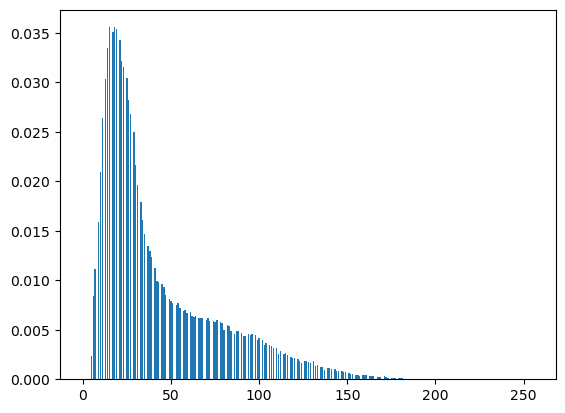

In [19]:
# make a histogram of the pixel intensities assuming the image has gray scale values between 0 and 256
img_hist = np.histogram(img_masked, 256)

# numpy's histogram returns the bin sizes, too. only look at the counts in each gray level
img_hist = np.asarray(img_hist[0]).astype(np.float64)

# since most of the image is black and we only care about the stuff in the region, set the bin for black pixels=0
img_hist[0] = 0

# normalize to scale it from zero to one
img_hist = img_hist/img_hist.sum()

plt.bar(range(0, 256),img_hist)

This histogram is the probability distribution of gray scale values in our ROI. We can now compute some feature from this PDF that are indicative of texture. 

In [21]:
# a list of the normalized pixel values from 0 to 256.
vec = np.arange(0, len(img_hist)).astype(np.float64) / (len(img_hist) - 1)

# get the bins with nonzero number of pixels in them.
ind = np.nonzero(img_hist)[0]

# mean grey value
mu = np.sum(vec[ind] * img_hist[ind])

# variance in the gray scale values
var = np.sum((((vec[ind] - mu)**2) * img_hist[ind]))

# standard deviation of the gray scale values
std =  np.sqrt(var)

# contrast - a number indicating the difference between a pixel it's neighbors over the whole image
cont = 1 - 1/(1 + var)

# 3rd moment. A metric that indicates the distribution of gray values. 
# A high 3rd moment indicates that there are more bight pixels. Low 3rd moment says the opposite. A 3rd moment of zero
# means there is a roughly equal distribution of light and dark pixels
thir = np.sum(((vec[ind] - mu)**3)*img_hist[ind])

# Uniformity - how flat the intensities are. If the image a single value, uniformity=1
uni = np.sum(img_hist[ind]**2)

# Entropy is a measure of randomness in the pixel intenisties. 
ent = - np.sum(img_hist[ind] * np.log2(img_hist[ind]))

# add them all the feature vector
img_features.extend([mu, var, std, cont, thir, uni, ent])

These metrics computed from the histogram of intensities contain a great deal of information regarding the gray levels in the ROI. But they contain no information about the relative positions of the gray levels. That is, it might tell us that there is a repeating pattern, but not what the pattern is. 

The last set of texture metrics we will add to these feature vectors is thus the gray level coocurrence matrix (GLCM). The GLCM contains the probability of pixel pairs having the same value at a defined distance and orientation from each other. 

skimage's *graycomatrix* will compute such a matrix at a set of defined distances and orientations across a whole image. It will return a 4D matrix with the value at each combination of distances and orientation at every coordinate in the region.

This matrix is too big to save as a feature and probably contains redundent information anyway. Using skimage's *greycoprops* will compute summary statistics at each pair of distances and angles. Here we will tell it to comptute 4 summary statistics:

1. contrast - the sum of squared differences between the pixel pairs
2. dissimilarity - sum of the absolute differences between the pixel pair
3. energy - the square root of the sum of the squared probabilities of each pair.
4. correlation - the of each pair of values at the distance and angle

In [24]:
# first, define the distances to use (in pixels)
dist = [1, 2, 4, 16, 32, 64]

# then define the angles (in radians)
ang = [0, pi/4, pi/2, 3*pi / 4]

# compute the matrix from the masked image (changed from 'greycomatrix' (depricated) to 'graycomatrix')
pp = feature.graycomatrix(img_masked, distances = dist, 
                         angles = ang, normed = True)

# define an output matrix for the metrics
grey_mat = np.zeros([24,2]) 

# set a flag to move the index of the output matrix
flag = 0

# tell skimage which metrics to compute and iterate over them
grey_props = ['contrast', 'homogeneity', 'energy', 'correlation']
for name in grey_props:
    
    # actually compute the features (changed from 'greycoprops' (depricated) to 'graycoprops')
    stat = feature.graycoprops(pp, name)
    
    # take the mean and standard deviation of the metrics to further compress them
    grey_mat[flag:flag+6,0] = np.mean(stat,1)
    grey_mat[flag:flag+6,1] = np.std(stat,1)
    flag += 6

# Add to feature Vector
img_features.extend(grey_mat[:,0])
img_features.extend(grey_mat[:,1])

print("total features: ", str(len(img_features)))

total features:  125


We have thus converted our diatom ROI into a vector of 72 numbers. When preparing to train and test an ensemble or margin classifier, all the labeled images would be run through such a routine. Indeed, the training and test sets for the next module have already been processed in this way.

There are a multitude of possible useful features for such things. Settling on which features are most appropriate for your application takes time and testing. 